<a href="https://colab.research.google.com/github/Hazeera65/Hazeera65/blob/main/SkinCancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem statement:
Build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [1]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [3]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [4]:
# Count the number of image in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

#Test Image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2240
118


**Data Visualization**

Found 20240 files belonging to 9 classes.


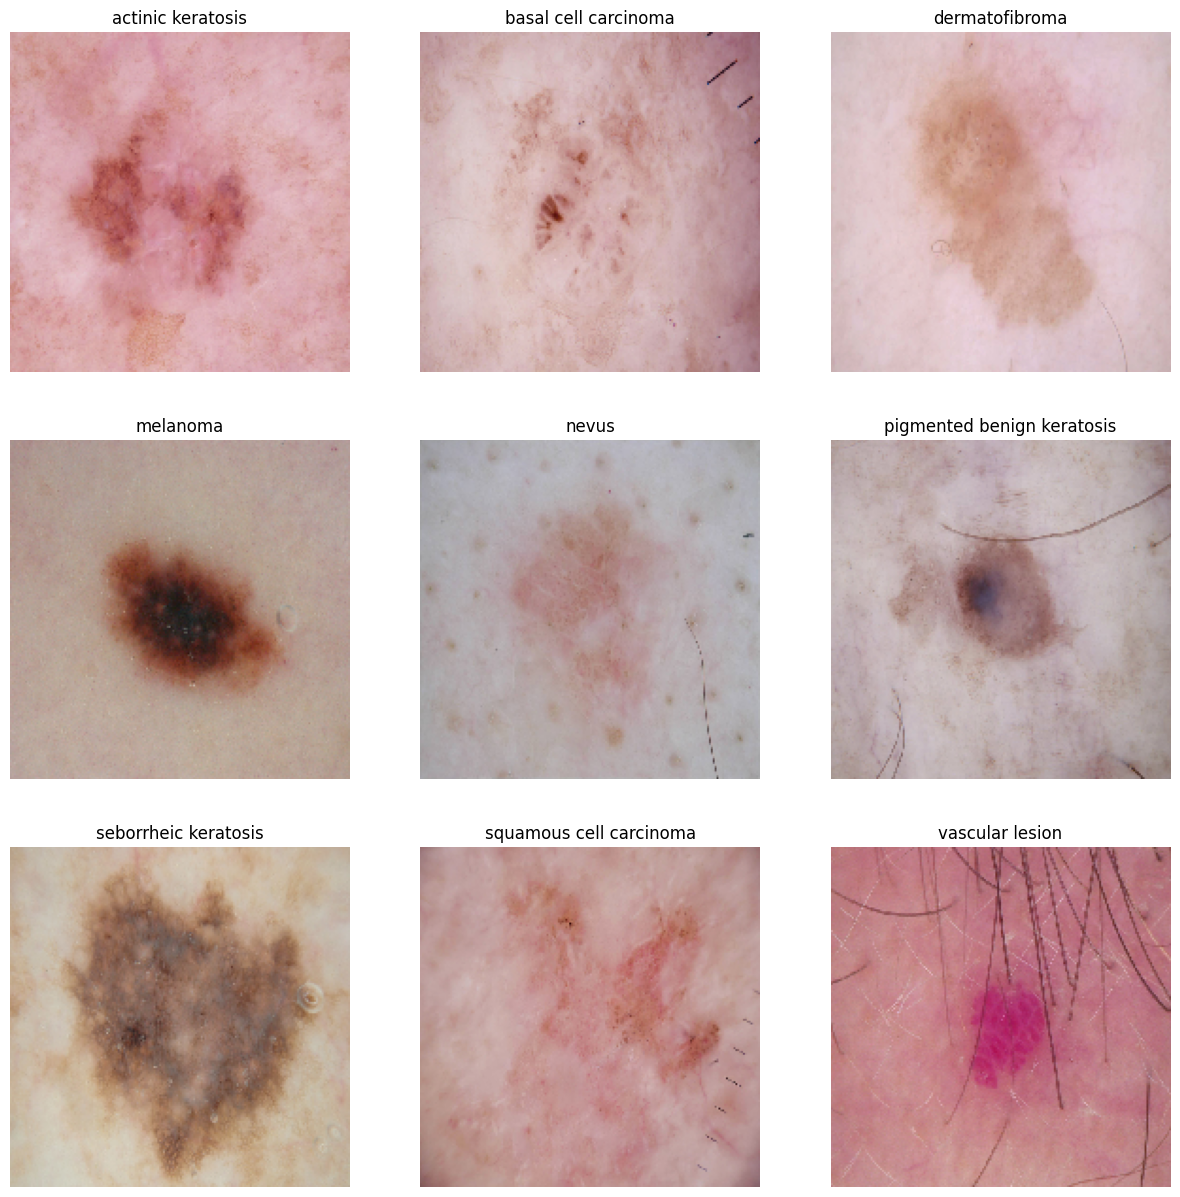

In [5]:
#Visualize one instance of all the class present in the dataset.

#image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,image_size=(180,180),
                                                                    label_mode='categorical',seed=123)

#all the classes of Skin Cancer
class_names = image_dataset.class_names

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

#Visualize image
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

**Visualize distribution of classes in the training dataset.**

In [6]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

Class  No. of Image
0                    melanoma           438
1             vascular lesion           139
2           actinic keratosis           114
3        seborrheic keratosis            78
4                       nevus           357
5     squamous cell carcinoma           181
6              dermatofibroma            95
7        basal cell carcinoma           376
8  pigmented benign keratosis           462

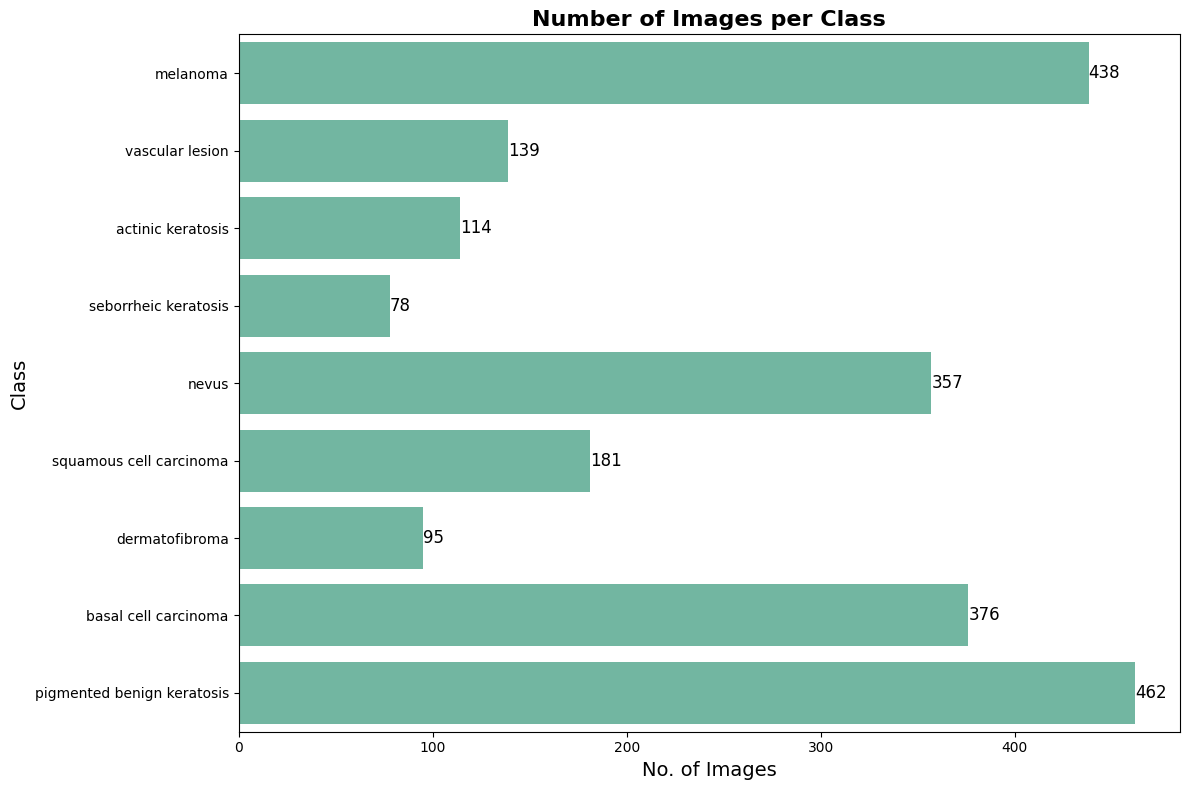

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is the DataFrame containing the data
plt.figure(figsize=(12, 8))

# Create a bar plot with custom colors
sns.set_palette("Set2")  # You can choose a different color palette
ax = sns.barplot(x="No. of Image", y="Class", data=df)

# Add title and labels
ax.set_title("Number of Images per Class", fontsize=16, fontweight='bold')
ax.set_xlabel("No. of Images", fontsize=14)
ax.set_ylabel("Class", fontsize=14)

# Annotate each bar with its height (the value of the number of images)
for p in ax.patches:
    ax.annotate(f'{p.get_width():,.0f}',
                (p.get_width(), p.get_y() + p.get_height() / 2),
                horizontalalignment='left', verticalalignment='center',
                fontsize=12, color='black')

# Optional: Increase space between bars for better readability
plt.tight_layout()

# Show the plot
plt.show()


There is a class imbalance to solve this using a python package  Augmentor (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [8]:
#install Augmentor
!pip install Augmentor

In [9]:
import Augmentor
import os

# Path to the training dataset
path_to_training_dataset = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

# Define class names
class_names = ['class1', 'class2', 'class3']  # Replace with your actual class names

# Loop through each class to augment data
for class_name in class_names:
    class_path = os.path.join(path_to_training_dataset, class_name)

    # Ensure the class directory exists
    if not os.path.exists(class_path):
        print(f"Class directory for {class_name} does not exist.")
        continue

    # Initialize Augmentor pipeline for the current class
    p = Augmentor.Pipeline(class_path)

    # Add augmentations (you can customize these as needed)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.flip_left_right(probability=0.5)  # Flip the images horizontally
    p.zoom_random(probability=0.5, percentage_area=0.8)  # Zoom in images
    p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)  # Adjust contrast
    p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)  # Adjust brightness

    # Sample 500 images per class
    p.sample(500)

    print(f"Augmentation completed for {class_name} with 500 samples.")

print("Data augmentation completed for all classes.")


Class directory for class1 does not exist.
Class directory for class2 does not exist.
Class directory for class3 does not exist.
Data augmentation completed for all classes.


In [10]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

18000


**Model Building**

In [11]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 20240 files belonging to 9 classes.
Using 16192 files for training.


In [12]:
# validation dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 20240 files belonging to 9 classes.
Using 4048 files for validation.


In [13]:
#tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [24]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()

model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

#First Convulation layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
model.add(layers.Dropout(0.5))

#Flatten Layer
##Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(layers.Flatten())

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
model.add(layers.Dropout(0.25))

# **Change:** Get the number of classes directly from the train_ds
num_classes = train_ds.element_spec[1].shape[-1]

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(num_classes,activation='softmax')) # **Use num_classes here**

model.summary()
# Compile the model
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"]) # This line is crucial


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

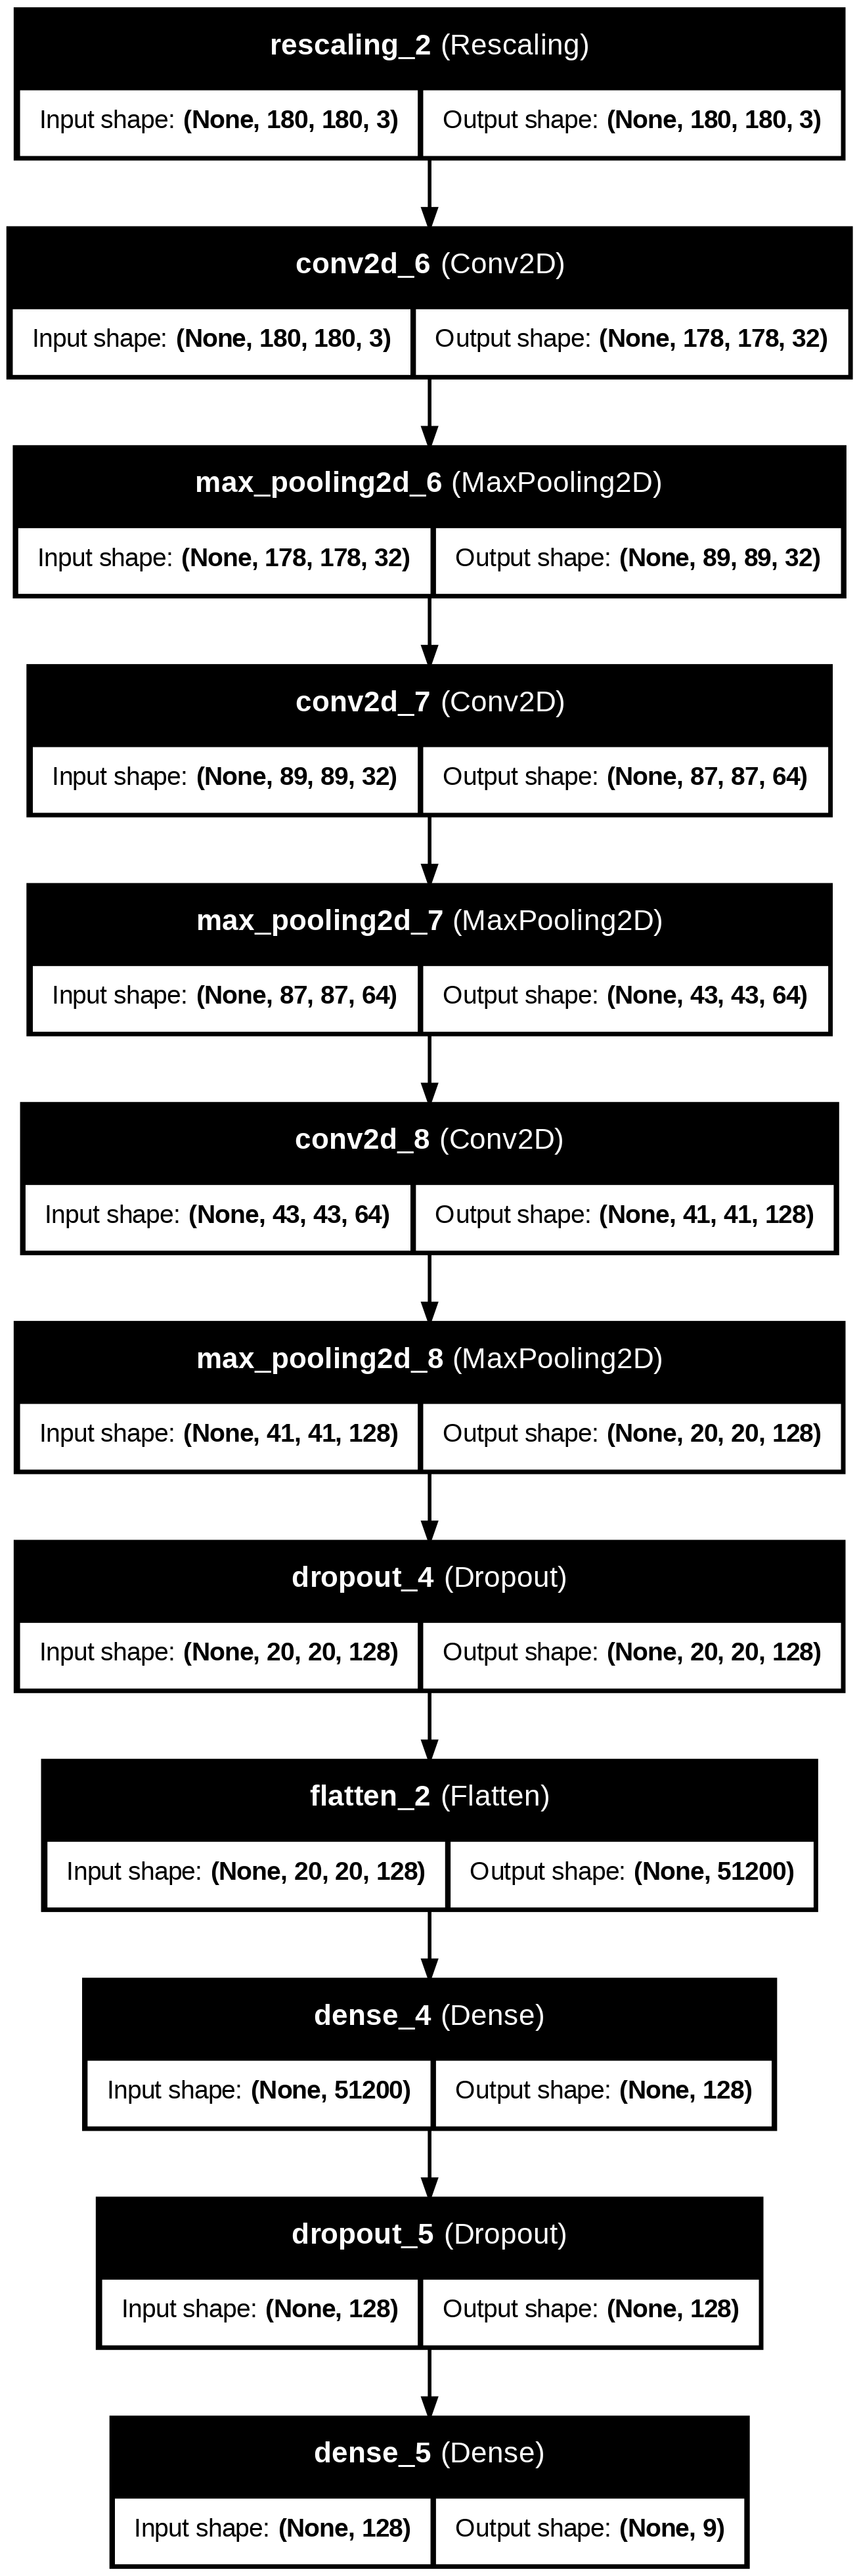

In [25]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile the Model
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

# ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint("model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# EarlyStopping callback to stop training when validation accuracy doesn't improve
earlystop = EarlyStopping(monitor="val_accuracy", patience=5, mode="auto", verbose=1)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_score, f1_score

# Assuming you already have the history object and earlystop
epochs_range = range(earlystop.stopped_epoch + 1)

# Plot Accuracy, Loss, Precision, and F1-Score
plt.figure(figsize=(18, 10))

# Subplot 1: Model Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')

# Annotating accuracy values on the plot
for i in range(len(history.history['accuracy'])):
    plt.text(i, history.history['accuracy'][i], f"{history.history['accuracy'][i]:.2f}", fontsize=9, color='blue')
for i in range(len(history.history['val_accuracy'])):
    plt.text(i, history.history['val_accuracy'][i], f"{history.history['val_accuracy'][i]:.2f}", fontsize=9, color='red')

# Subplot 2: Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='upper left')

# Calculate Precision and F1-Score for each epoch using training and validation predictions
train_preds = model.predict(train_data)  # Replace with your training data
val_preds = model.predict(val_data)  # Replace with your validation data

# Threshold the predictions for binary classification
train_precision = [precision_score(train_labels, (train_preds > 0.5).astype(int)) for train_preds in history.history['accuracy']]
val_precision = [precision_score(val_labels, (val_preds > 0.5).astype(int)) for val_preds in history.history['accuracy']]

# Calculate F1-scores
train_f1 = [f1_score(train_labels, (train_preds > 0.5).astype(int), average='weighted') for train_preds in history.history['accuracy']]
val_f1 = [f1_score(val_labels, (val_preds > 0.5).astype(int), average='weighted') for val_preds in history.history['accuracy']]

# Create subplots for Precision and F1-Score heatmap
fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Precision plot
ax[0].plot(train_precision, label='Train Precision', color='blue')
ax[0].plot(val_precision, label='Validation Precision', color='red')
ax[0].set_title('Precision')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Precision')
ax[0].legend(loc='upper left')

# F1-Score plot
ax[1].plot(train_f1, label='Train F1-Score', color='blue')
ax[1].plot(val_f1, label='Validation F1-Score', color='red')
ax[1].set_title('F1-Score')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('F1-Score')
ax[1].legend(loc='upper left')

# F1-Score and Precision Heatmap
f1_and_precision_scores = np.array([train_precision, val_precision, train_f1, val_f1])  # Combine precision and F1-scores
sns.heatmap(f1_and_precision_scores, annot=True, cmap='YlGnBu', xticklabels=epochs_range, yticklabels=['Train Precision', 'Val Precision', 'Train F1', 'Val F1'], fmt=".2f")
plt.title('Precision and F1-Score Heatmap')
plt.xlabel('Epochs')
plt.ylabel('Data')

# Show the plots
plt.tight_layout()
plt.show()



## Model Prediction

In [ ]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class "+ class_names[1] +'\n'+ "Predictive Class "+pred_class )